In [142]:
%matplotlib inline

In [177]:
import numpy as np
import fiona
from shapely.geometry import Polygon,shape,MultiPoint,Point
import os.path
import matplotlib.pyplot as plt
from functools import partial
import pyproj
from shapely.ops import transform

In [144]:
shapefile = os.path.join(os.path.expanduser('~'),'data','landslide','northridge','northridge_dd.shp')

In [195]:
f = fiona.collection(shapefile,'r')
shapes = list(f)
xmin,ymin,xmax,ymax = f.bounds
f.close()
print len(shapes)
print shapes[0]['geometry']['type']

11111
Polygon


In [146]:
def plotPolygon(shape):
    #shape is a dictionary with keys 'geometry' and 'coordinates'
    #coordinates is a sequence of sequences of tuples of vertices of the polygon
    coords = shape['geometry']['coordinates']
    f = plt.figure()
    for segment in coords:
        x,y = zip(*segment)
        print 'Plotting %i vertices from a shape' % len(x)
        plt.plot(x,y)
        plt.hold(True)

In [146]:
def plotShapes(shapes):
    #shape is a dictionary with keys 'geometry' and 'coordinates'
    #coordinates is a sequence of sequences of tuples of vertices of the polygon
    coords = shape['geometry']['coordinates']
    f = plt.figure()
    for segment in coords:
        x,y = zip(*segment)
        print 'Plotting %i vertices from a shape' % len(x)
        plt.plot(x,y)
        plt.hold(True)

In [147]:
print xmin,xmax,ymin,ymax
res = 10.0
nrows = int(((ymax - ymin) * 111191)/res)
ncols = int(((xmax - xmin) * 111191 * np.cos(np.radians(np.mean((ymin,ymax))))))
print nrows,ncols
print nrows*ncols
print np.mean((xmin,xmax))

-119.074055183 -118.169284954 34.0004506188 34.6703072669
7448 83072
618720256
-118.621670069


In [148]:
latmiddle = ymin + (ymax-ymin)/2.0
lonmiddle = xmin + (xmax-xmin)/2.0
projstr = '+proj=ortho +lat_0=%.4f +lon_0=%.4f +x_0=0.0 +y_0=0.0'

proj = pyproj.Proj(projparams=projstr % (latmiddle,lonmiddle))
project = partial(
    pyproj.transform,
    pyproj.Proj(projparams='+proj=latlong'),
    proj)

In [149]:
g1 = shape(shapes[0]['geometry'])

In [150]:
g2 = transform(project, g1)

In [151]:
x,y = zip(*g2.boundary.coords)

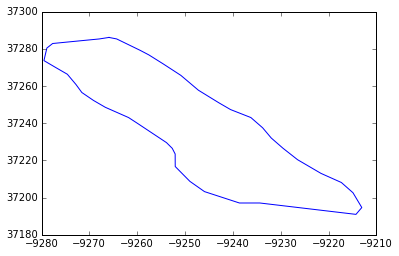

In [152]:
plt.plot(x,y)

In [153]:
ulx,uly = proj(xmin,ymax)
llx,lly = proj(xmin,ymin)
urx,ury = proj(xmax,ymax)
lrx,lry = proj(xmax,ymin)
pxmin = np.min((ulx,llx))
pxmax = np.max((urx,lrx))
pymin = np.min((lly,lry))
pymax = np.max((uly,ury))
print pxmin,pxmax,pymin,pymax

-41746.3182989 41751.8426918 -37193.2310869 37373.730265


In [154]:
res = 10.0
xvar = np.arange(pxmin,pxmax+res,res)
yvar = np.arange(pymin,pymax+res,res)
ncols = len(xvar)
nrows = len(yvar)
print ncols
print nrows

8351
7458


In [156]:
polyxmin = np.min(x)
polyxmax = np.max(x)
polyymin = np.min(y)
polyymax = np.max(y)
print polyxmin,polyxmax,polyymin,polyymax

-9279.50912206 -9213.05070223 37190.9826141 37286.1100104


In [162]:
#find the highest index in xvar where polyxmin - xvar is positive
leftcol = np.where((polyxmin - xvar) > 0)[0].argmax()
print 'Left column is %i' % leftcol
print 'Value at left column is %.3f' %  xvar[leftcol]
print 'Left edge of polygon is %.3f' %  polyxmin

#find the lowest index in xvar where xvar - polyxmax is positive
rightcol = np.where((xvar - polyxmax) > 0)[0][0]
print 'Right column is %i' % rightcol
print 'Value at right column is %.3f' %  xvar[rightcol]
print 'Right edge of polygon is %.3f' %  polyxmax

#find bottom row
bottomrow = np.where((polyymin - yvar) > 0)[0].argmax()
print 'Bottom row is %i' % bottomrow
print 'Value at Bottom row is %.3f' %  yvar[bottomrow]
print 'Bottom edge of polygon is %.3f' %  polyymin

#find top row
toprow = np.where((yvar - polyymax) > 0)[0][0]
print 'Top row is %i' % toprow
print 'Value at top row is %.3f' %  yvar[toprow]
print 'Top edge of polygon is %.3f' %  polyymax

Left column is 3246
Value at left column is -9286.318
Left edge of polygon is -9279.509
Right column is 3254
Value at right column is -9206.318
Right edge of polygon is -9213.051
Bottom row is 7438
Value at Bottom row is 37186.769
Bottom edge of polygon is 37190.983
Top row is 7448
Value at top row is 37286.769
Top edge of polygon is 37286.110


[(-9226.3182988812623, 37196.768913128319), (-9216.3182988812623, 37196.768913128319), (-9246.3182988812623, 37206.768913128319), (-9236.3182988812623, 37206.768913128319), (-9226.3182988812623, 37206.768913128319), (-9246.3182988812623, 37216.768913128319), (-9236.3182988812623, 37216.768913128319), (-9226.3182988812623, 37216.768913128319), (-9246.3182988812623, 37226.768913128319), (-9236.3182988812623, 37226.768913128319), (-9256.3182988812623, 37236.768913128319), (-9246.3182988812623, 37236.768913128319), (-9236.3182988812623, 37236.768913128319), (-9256.3182988812623, 37246.768913128319), (-9246.3182988812623, 37246.768913128319), (-9266.3182988812623, 37256.768913128319), (-9256.3182988812623, 37256.768913128319), (-9266.3182988812623, 37266.768913128319), (-9256.3182988812623, 37266.768913128319), (-9276.3182988812623, 37276.768913128319), (-9266.3182988812623, 37276.768913128319)]


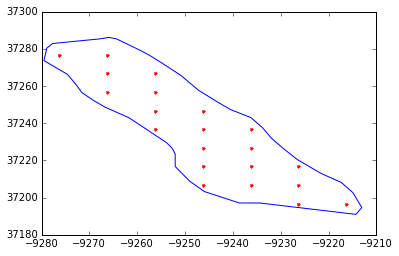

In [192]:
#Now generate the mesh of points that fall inside this polygon
xp = np.arange(xvar[leftcol],xvar[rightcol]+res,res)
yp = np.arange(yvar[bottomrow],yvar[toprow]+res,res)
xmesh,ymesh = np.meshgrid(xp,yp)
xy = zip(xmesh.flatten(),ymesh.flatten())
yespoints = []
x,y = zip(*g2.boundary.coords)
plt.plot(x,y,'b')
plt.hold(True)
for point in xy:
    if g2.contains(Point(point)):
        yespoints.append(point)
        plt.plot(point[0],point[1],'r.')
print yespoints

In [190]:
print xy

[(-9286.3182988812623, 37186.768913128319), (-9276.3182988812623, 37186.768913128319), (-9266.3182988812623, 37186.768913128319), (-9256.3182988812623, 37186.768913128319), (-9246.3182988812623, 37186.768913128319), (-9236.3182988812623, 37186.768913128319), (-9226.3182988812623, 37186.768913128319), (-9216.3182988812623, 37186.768913128319), (-9206.3182988812623, 37186.768913128319), (-9286.3182988812623, 37196.768913128319), (-9276.3182988812623, 37196.768913128319), (-9266.3182988812623, 37196.768913128319), (-9256.3182988812623, 37196.768913128319), (-9246.3182988812623, 37196.768913128319), (-9236.3182988812623, 37196.768913128319), (-9226.3182988812623, 37196.768913128319), (-9216.3182988812623, 37196.768913128319), (-9206.3182988812623, 37196.768913128319), (-9286.3182988812623, 37206.768913128319), (-9276.3182988812623, 37206.768913128319), (-9266.3182988812623, 37206.768913128319), (-9256.3182988812623, 37206.768913128319), (-9246.3182988812623, 37206.768913128319), (-9236.318

In [181]:
print g2.exterior.coords[:]

[(-9265.908436670825, 37286.11001035358), (-9264.303192032625, 37285.30481151431), (-9259.39668763359, 37279.173843408695), (-9257.5777718972, 37276.725402533535), (-9254.533010993451, 37271.81891715925), (-9250.875578847035, 37265.69908812365), (-9247.219959988472, 37257.74433291016), (-9242.959405797374, 37251.006954357705), (-9240.496353381852, 37247.32999592528), (-9236.243786267707, 37243.03901639459), (-9233.782547217532, 37237.52713162072), (-9231.97705864594, 37232.02031123264), (-9229.515819752438, 37226.50842610294), (-9226.48267298743, 37220.37848627692), (-9221.587782783015, 37213.02406215852), (-9217.325415534682, 37208.12160765145), (-9214.895391156386, 37202.6092161806), (-9213.050702228285, 37194.65650000858), (-9214.271936398454, 37190.982614050175), (-9234.383546499086, 37197.10262164913), (-9238.629688749004, 37197.096597619966), (-9245.94019119554, 37203.22000809961), (-9248.994751320586, 37208.73796883336), (-9252.057298228721, 37216.70232893267), (-9252.0652849769